In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from scipy.interpolate import interp2d
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from labellines import labelLine
from PIL import Image

In [3]:
cities_populations = pd.DataFrame(columns=['city', 'population'])
for name in ['miami', 'ma', 'bogota']:
    pop = pd.read_csv(f'confinement/cities3/{name}/Poparea.txt', sep=' ', header=None)[1].sum()
    cities_populations = pd.concat([cities_populations, pd.DataFrame([[name, pop]], columns=['city', 'population'])])
cities_populations = cities_populations.set_index('city')['population']
cities_populations

city
miami     5590269
ma        4146213
bogota    7129506
Name: population, dtype: object

/tmp/ipykernel_8409/1967642562.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('inferno_r')


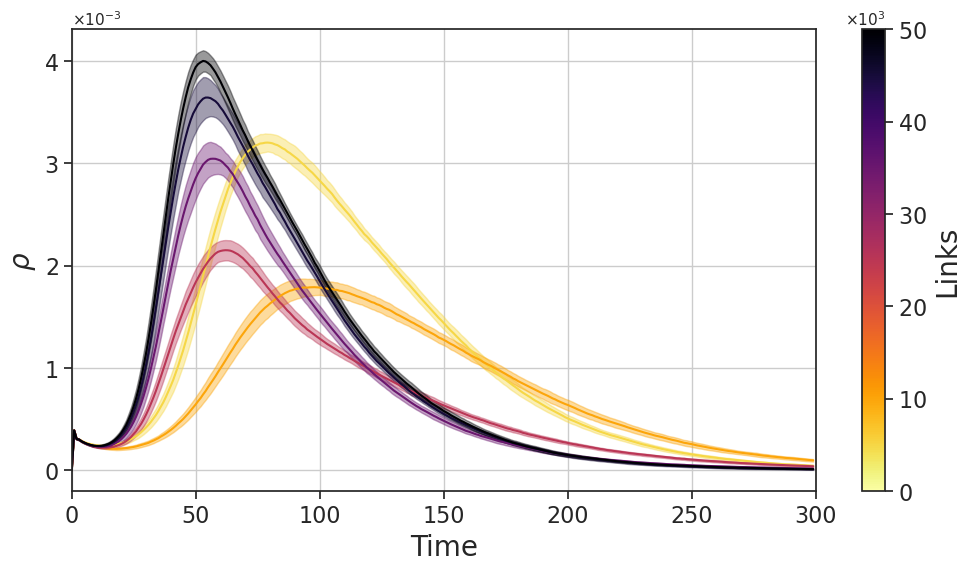

In [25]:
fig,ax = plt.subplots(figsize=(12,6))
label_size = 16
abc_size = 16*1.6

# data = pd.read_csv('curves_confinement/out/trajectories/ma_beta_4,0_80k.txt', sep='\t') //OLD ONE
name = 'bogota'
data = pd.read_csv(f'curves_confinement/out/trajectories/{name}_beta_3,0_150k.txt', sep='\t')
data['error'] = data['error'] * np.sqrt(1)
data['infected'] = data['infected'] / cities_populations.loc['bogota']
data['error'] = data['error'] / cities_populations.loc['bogota']

links = data['links'].drop_duplicates()
# links = links[links.isin([1237, 2474, 3711, 6185, 12371, 22269, 40826])]

colors = cm.get_cmap('inferno_r')

sns.set_theme(style="ticks")

for l in links:
    ax.plot('time', 'infected', color = colors((l)/(links.max())), data=data[data['links'] == l],
        label=l)
    ax.fill_between(x=data[data['links'] == l]['time'], y1=data[data['links'] == l]['infected']+ 2*data[data['links'] == l]['error'],
        y2=data[data['links'] == l]['infected']-2*data[data['links'] == l]['error'], color=colors((l)/(links.max())), alpha=0.4) 
sm = plt.cm.ScalarMappable(cmap=colors, norm=Normalize(0, links.max()))
cbar=fig.colorbar(sm, ax=ax)


ax.set_xlabel('Time', size=20)
ax.set_ylabel(r'$\rho$', size=20)
ax.tick_params(labelsize=16)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('Links', size=20)
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3), useMathText=True)

ax.grid('True')

ax.set_xlim(0, 300)

fig.savefig(f'figures/figs_feb24/curves_{name}.pdf', bbox_inches='tight', dpi=300)

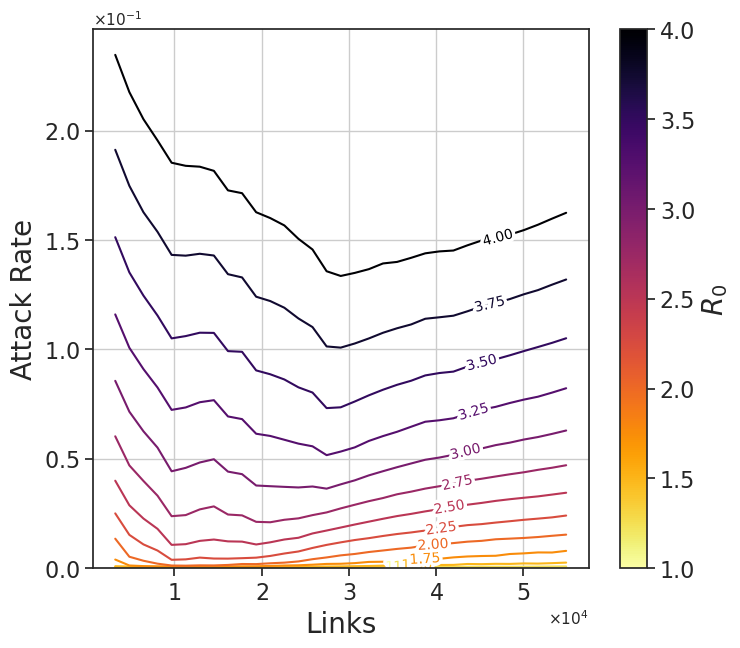

In [12]:
fig,ax = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

name = 'bogota'
beta_max,beta_min = 4, 1

heatmap = pd.read_csv(f'confinement/out/attackRateMap/{name}.txt', sep='\t', names=['beta','links', 'attackRate', 'error'])
heatmap = heatmap[heatmap['beta'] <= beta_max]
heatmap['attackRate'] = heatmap['attackRate'] / cities_populations.loc[name]
# heatmap = heatmap[heatmap['beta'].isin(heatmap['beta'].drop_duplicates()[::2]) & ((heatmap['beta'] > 1.7) | (heatmap['beta']==1.5))]
# heatmap = heatmap.drop(heatmap[heatmap['beta'].isin([1])].index, axis=0)
pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')

linearColor = mpl.colormaps['inferno_r']
for i,val in enumerate(heatmap['beta'].drop_duplicates()):
    links_text = 45203
    color=linearColor((val-beta_min)/(beta_max-beta_min))
    ax.plot('links', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.2f}')
    # ax.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
    #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

labelLines(ax.get_lines(), zorder=2.5, xvals=(35000, 48000), outline_width=5, fontsize=10)

# COLORBAR
sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
#sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)

ax.set_xlabel('Links', size=20)
ax.set_ylabel('Attack Rate', size=20)
ax.tick_params(labelsize=16)

ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)

cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel(r'$R_0$', size=20)

ax.grid('True')

ax.set_ylim(0,)

fig.savefig(f'figures/figs_feb24/attackRate_{name}.pdf', bbox_inches='tight', dpi=300)

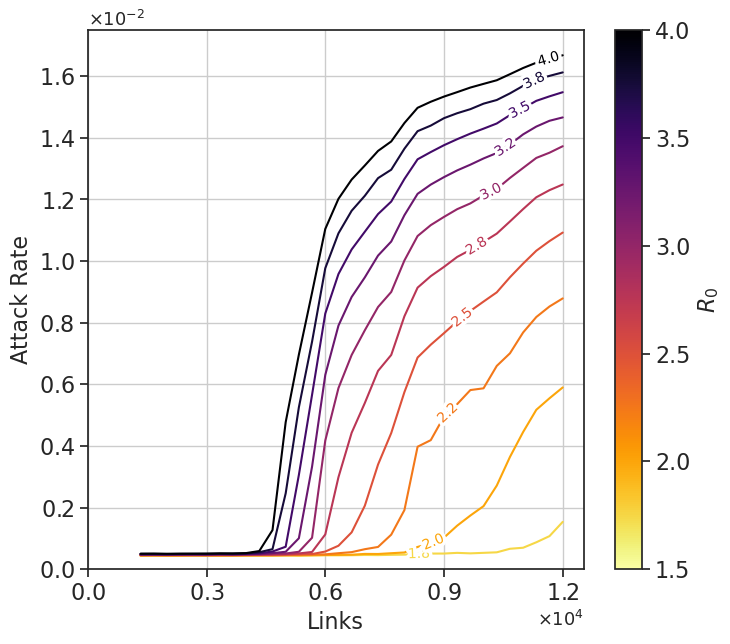

In [11]:
fig,ax1 = plt.subplots(figsize=(8,7))
label_size = 16
abc_size = 16*1.6

beta_max,beta_min = 4, 1.5
name = 'miami'

heatmap = pd.read_csv(f'confinement/out/attackRateMap/{name}.txt', sep='\t')
heatmap = heatmap[(heatmap['beta'] <= beta_max) & (heatmap['beta'] > beta_min)]
heatmap['attackRate'] = heatmap['attackRate'] / cities_populations.loc[name]


pivotTable = pd.pivot_table(data = heatmap, index = 'beta', columns = 'links', values='attackRate')

linearColor = mpl.colormaps['inferno_r']
for i,val in enumerate(heatmap['beta'].drop_duplicates()):
    links_text = 11472
    color=linearColor((val-beta_min)/(beta_max-beta_min))
    ax1.plot('links', 'attackRate', data=heatmap[heatmap['beta']==val], color=color, label=f'{val:.1f}')
    # ax1.text(links_text, heatmap[(heatmap['beta']==val) & (heatmap['links']==links_text)]['attackRate'].max(),
    #         r'$R_0$ = ' + f'{val:.2f}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=1, pad=-1), ha='center', va='center')

labelLines(plt.gca().get_lines(), zorder=2.5, xvals=(8000, 12000), outline_width=5, fontsize=10)

# COLORBAR
sm = plt.cm.ScalarMappable(cmap=linearColor, norm=Normalize(vmin=beta_min, vmax=beta_max))
#sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)

ax1.set_xlabel('Links', size=label_size)
ax1.set_ylabel('Attack Rate', size=label_size)
ax1.tick_params(labelsize=label_size)
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(5))
# ax1.xaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
# ax1.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k')
ax1.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText=True)
ax1.xaxis.offsetText.set_fontsize(label_size*0.8)
ax1.yaxis.offsetText.set_fontsize(label_size*0.8)

cbar.ax.tick_params(labelsize=label_size)
cbar.ax.set_ylabel(r'$R_0$', size=label_size)

ax1.grid('True')
ax1.set_ylim(0,)
ax1.set_xlim(0,)

fig.savefig(f'figures/figs_feb24/attackRate_{name}.pdf', bbox_inches='tight', dpi=300)

In [109]:
from matplotlib.ticker import ScalarFormatter
class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"

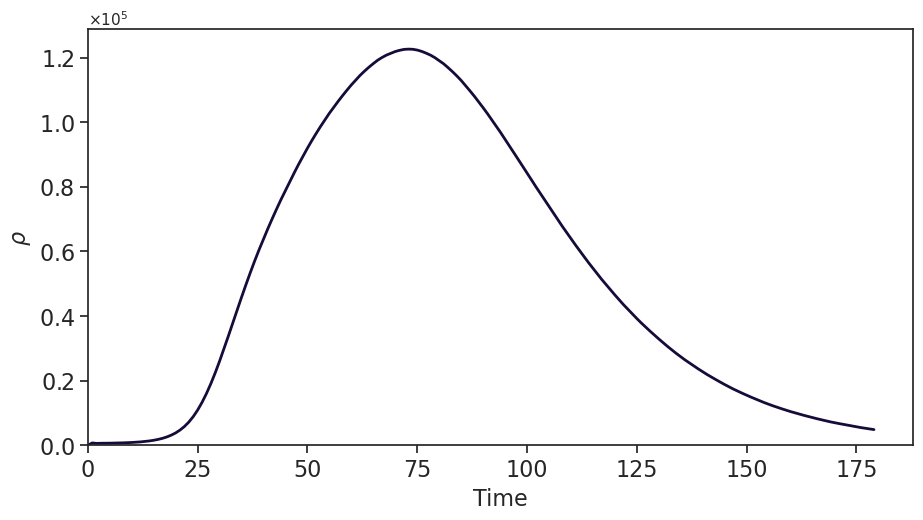

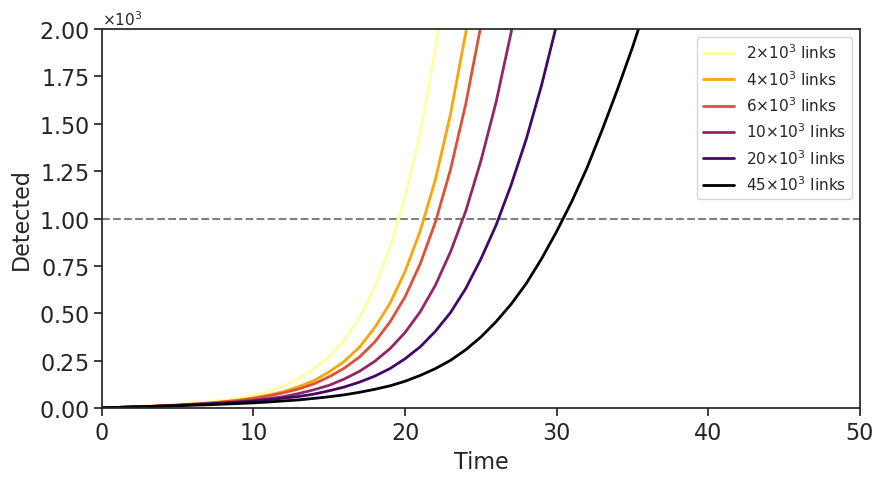

In [44]:
fig,ax = plt.subplots(1, 1, figsize=(9, 5))

label_size = 16
abc_size = 16*1.6

colormap = mpl.colormaps['inferno_r']

name = 'bogota'
betastr = '4,0'

curves = pd.read_csv('curves_times/out/bogota_20k_180d_beta_4,0.txt', sep='\t')
total_infected = curves[curves['links']==0]
curves = curves.drop(curves[curves['links']==0].index)
curves['cumulative_infected'] = curves.groupby('links')['infected'].cumsum(axis=0)
links_list = curves['links'].unique()

ax.plot('time', 'infected', data=total_infected, label='', color = mpl.colormaps['inferno_r'](0.9), lw=2)
ax.set_xlim(0,)
ax.set_ylim(0,)

ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

fig.tight_layout()
fig.show()

ax.set_xlabel('Time', size=label_size)
ax.set_ylabel(r'$\rho$', size=label_size)
ax.tick_params(labelsize=label_size)

fig.savefig(f'figures/figs_feb24/time_infected_{name}.pdf', bbox_inches='tight', dpi=300)

fig1,ax1 = plt.subplots(1, 1, figsize=(9, 5))

ax1.axhline(y=1000, color='grey', linestyle='--')
for i,links in enumerate(links_list):
    ax1.plot('time', 'cumulative_infected', data = curves[curves['links']==links], lw=2, 
             color = colormap(i/(len(links_list)-1)), label = '{:.0f}'.format(links/1000) +r'$\times 10^3$ links')
ax1.set_xlim(0,50)
ax1.set_ylim(0,2000)
ax1.legend()

# only one digit per tick on the y axis

ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useMathText=True)

ax1.set_xlabel('Time', size=label_size)
ax1.set_ylabel('Detected', size=label_size)
ax1.tick_params(labelsize=label_size)

fig1.tight_layout()
fig1.show()
fig1.savefig(f'figures/figs_feb24/time_detected_{name}.pdf', bbox_inches='tight', dpi=300)

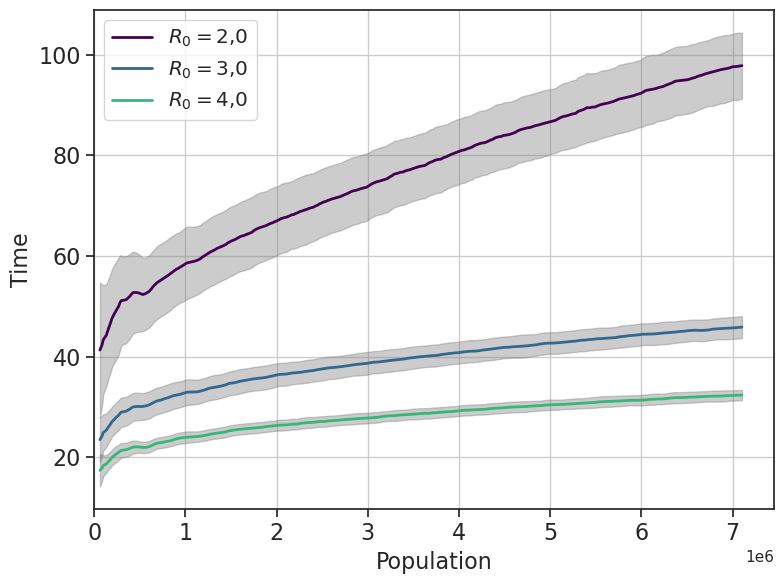

In [28]:
sns.set_theme(style="ticks")

fig,ax = plt.subplots(figsize=(8,6))

label_size = 16
abc_size = 16*1.6

colormap = mpl.colormaps['viridis']

name = 'bogota'
betastr = '4,0'
for i,betastr in enumerate(['2,0', '3,0', '4,0']):
    heatmap = pd.read_csv('times/out/' + name + f'_{20}k_120d_beta_' + betastr +
                            '.txt', sep='\t')
    heatmap['time'] = heatmap['time'].rolling(window=4).mean()
    heatmap['time_error'] = heatmap['time_error'].rolling(window=4).mean()
    heatmap['time_error'] = heatmap['time_error']/np.sqrt(23) * 1.96
 

    #rolling average of data
    color = colormap(i/3)
    ax.plot('population', 'time', data=heatmap, color=color, lw=2, label = r'$R_0 = $' + str(betastr))
    ax.fill_between(x=heatmap['population'], y1=heatmap['time']+ 1*heatmap['time_error'], y2=heatmap['time']-1*heatmap['time_error'], color='gray', alpha=0.4)

ax.legend(fontsize=label_size*0.9)
ax.set_xlabel('Population', size=label_size)
ax.set_ylabel('Time', size=label_size)
ax.tick_params(labelsize=label_size)
ax.set_xlim(0,)
ax.grid('True')
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

fig.tight_layout()
fig.show()
fig.savefig(f'figures/figs_feb24/EWT_{name}.pdf', bbox_inches='tight', dpi=300)

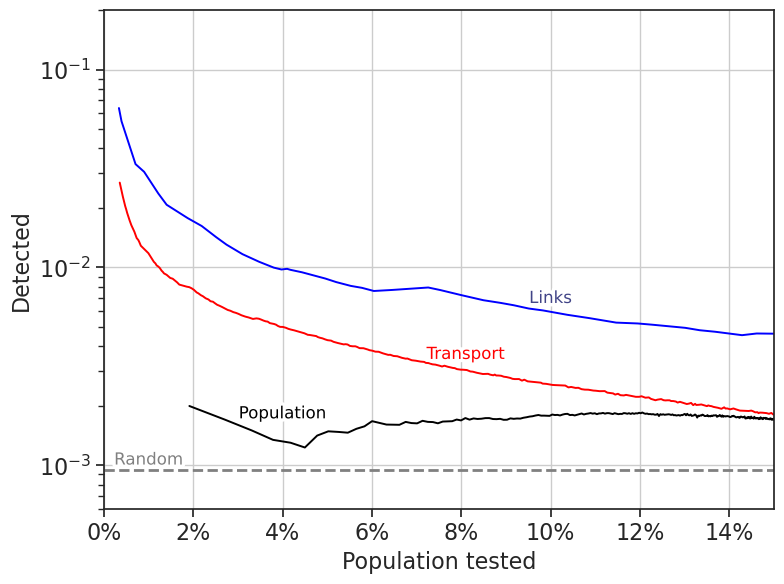

In [32]:
fig,ax = plt.subplots(figsize=(8,6))
label_size = 16
abc_size = 16*1.6

betastr = '4,0'
links = pd.read_csv('times/out/bogota_20k_30d_beta_' + betastr + '.txt', sep='\t')
transport = pd.read_csv('public_transport/times/out/bogota_transport_20k_beta_' + betastr + '.txt', sep='\t')
transport_population = pd.read_csv('public_transport/times/out/population/bogota_transport_20k_beta_' + betastr + '.txt', sep='\t')
lower = links['detected'].iloc[-1]

colormap = mpl.colormaps['viridis_r']

max_days,min_days = 17,9

total_tests = 20000 * 30

ax.plot(links['population'], links['detected']/total_tests, label='Links', c = 'blue', lw=1.4)
ax.plot(transport['population'], transport['detected']/total_tests, label='Transport', c = 'red', lw=1.4)
ax.plot(transport_population['population'], transport_population['detected']/total_tests, label='Population', c = 'black', lw=1.4)


total_pop = links['population'].max()

#Plot again the lines with alpha = 0 to set the legend
# ax.plot(links['population'], links['detected'], label='Links', alpha=0)
# ax.plot(transport['population'], transport['detected'], label='Transport', alpha=0)
ax.plot([0,7100000], [lower/total_tests, lower/total_tests], label='Random', c = 'grey', lw = 2, linestyle = 'dashed')

labelLine(ax.get_lines()[-4], zorder=2.5, x=0.1*total_pop, outline_width=5, align=False, yoffset=0.001, color=colormap(0.8))
labelLine(ax.get_lines()[-3], zorder=2.5, x=0.081*total_pop, outline_width=5, align=False, yoffset=0.0006, color='red')
labelLine(ax.get_lines()[-2], zorder=2.5, x=0.04*total_pop, outline_width=5, align=False, yoffset=0.0005, color='black')
labelLine(ax.get_lines()[-1], zorder=2.5, x=0.01*total_pop, outline_width=5, align=False, yoffset=0.00012, color='grey')

# ax.legend(fontsize=label_size)


ax.set_xlabel('Population tested', size=label_size)
ax.set_ylabel('Detected', size=label_size)
ax.tick_params(labelsize=label_size)
ax.set_xlim(0, 0.15*total_pop)
ax.set_ylim(0.0006,0.2)


ax.set_yscale('log')

# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000) + 'k'))

percentages = np.array([0,2,4,6,8,10,12,14]) * total_pop / 100
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(percentages))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x/total_pop*100) + '%'))

ax.grid('True')

fig.tight_layout()
fig.show()
fig.savefig(f'figures/figs_feb24/detected_{name}.pdf', bbox_inches='tight', dpi=300)